In [205]:
fidx = 'irv2_'
midx = '1'
threshold = 0.0
print(fidx,midx,threshold)

irv2_ 1 0.0


In [206]:
# results from ens_oof.ipynb
mnames = ['irv2_a2']
weights = [1]
assert(len(mnames)==len(weights))
print(mnames)
print(weights)

['irv2_a2']
[1]


In [207]:
klist = ['resnet34_46']
print(klist)

['resnet34_46']


In [208]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

from scipy.special import logit, expit
from scipy.stats import rankdata

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [209]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [210]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [211]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [212]:
test_df.columns

Index(['Predicted'], dtype='object')

In [213]:
# save a base copy for reuse below
test_df0 = test_df.copy()
sub_dir = './sub/'

In [214]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

nfold = 20

firstm = True

klist

for m in mnames:

    firstf = True
    if m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
        # print('')
        # print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print('')
                print(fname)
                if m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    ptestb = logit(ptestb)
                else:
                    idb, ptestba, ptestb = pickle.load(open(fname,'rb'))
                
                ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                    
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,nr,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/irv2_a2_1_mm.pkl
-20.0 -7.3997097 20.0
(11702, 28) -20.0 -7.3997097 20.0

./sub/irv2_a2_2_mm.pkl
-20.0 -7.1641445 20.0
(11702, 28) -20.0 -7.1641445 20.0
[[1.         0.91120942]
 [0.91120942 1.        ]]

./sub/irv2_a2_3_mm.pkl
-20.0 -7.295483 20.0
(11702, 28) -20.0 -7.295483 20.0
[[1.         0.93369868]
 [0.93369868 1.        ]]

./sub/irv2_a2_4_mm.pkl
-20.0 -7.487007 20.0
(11702, 28) -20.0 -7.487007 20.0
[[1.         0.93536821]
 [0.93536821 1.        ]]
irv2_a2 0 (11702, 28) -20.0 -7.336587 20.0 0.06167138706448226


In [215]:
test_df.columns

Index(['Predicted', 'irv2_a2'], dtype='object')

In [216]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [217]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
print(np.corrcoef(f))   

['irv2_a2']
1.0


In [218]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [219]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [220]:
# # compute rank transform separately for every column
# n = m.shape[1] * m.shape[2]
# for i in range(m.shape[0]):
#     m[i] = np.array(rankdata(m[i].flatten()).astype(float)/n).reshape((m.shape[1],m.shape[2]))
# print(m.shape,m.min(),m.mean(),m.max())

In [221]:
# trans = m.reshape((m.shape[0],-1))
# trans = np.transpose(trans)
# print(trans.shape)
# fname = 'trans.csv'
# fdf = pd.DataFrame(trans)
# fdf.columns = clist
# fdf.to_csv(fname)
# print(fname)

In [222]:
# print(clist)
# print(np.corrcoef(trans, rowvar=False))  

In [223]:
weights = np.array(weights)
print(weights)

[1]


In [224]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [225]:
print(ens[1])

[ -2.53784013  -5.56024599  -4.34897566  -2.33859777  -3.70468473   1.65021241  -3.22337031
  -5.18756914 -10.16649532 -13.42277622 -12.54690552  -1.97839451  -1.32922399  -3.79614425
  -4.08576488  -8.14612675  -3.97669291  -6.30080175  -3.9148345   -3.31911945  -7.94656372
  -1.27891231  -2.54385281  -4.00089216  -1.1298492   -0.94659209  -2.04755402 -10.65542507]


In [226]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [227]:
# desired class proportions from lb probing
eps = 0.01
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.01, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.01, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.01, 25: 0.222493888, 26: 0.028806584, 27: 0.01}


In [228]:
idx = range(28)
loc = [name_label_dict[j] for j in idx]
lb = [desired[j] for j in idx]

df = pd.DataFrame({'idx':idx, 'loc':loc, 'lb':lb})
fname = 'lb.csv'
df.to_csv(fname,index=False)
print(fname)

lb.csv


In [229]:
# fixed global threshold
threshold = 0
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0
0 0.3624 0.4584 Nucleoplasm
1 0.0438 0.0387 Nuclear membrane
2 0.0753 0.1007 Nucleoli
3 0.0593 0.0370 Nucleoli fibrillar center
4 0.0753 0.0444 Nuclear speckles
5 0.0753 0.0637 Nuclear bodies
6 0.0438 0.0288 Endoplasmic reticulum
7 0.0753 0.0690 Golgi apparatus
8 0.0100 0.0015 Peroxisomes
9 0.0100 0.0009 Endosomes
10 0.0100 0.0006 Lysosomes
11 0.0438 0.0351 Intermediate filaments
12 0.0438 0.0259 Actin filaments
13 0.0142 0.0159 Focal adhesion sites
14 0.0438 0.0463 Microtubules
15 0.0100 0.0014 Microtubule ends
16 0.0288 0.0313 Cytokinetic bridge
17 0.0142 0.0423 Mitotic spindle
18 0.0288 0.0421 Microtubule organizing center
19 0.0593 0.0367 Centrosome
20 0.0100 0.0073 Lipid droplets
21 0.1261 0.1849 Plasma membrane
22 0.0288 0.0255 Cell junctions
23 0.0753 0.0772 Mitochondria
24 0.0100 0.0158 Aggresome
25 0.2225 0.2763 Cytosol
26 0.0288 0.0191 Cytoplasmic bodies
27 0.0100 0.0003 Rods & rings


In [230]:
ens.shape

(11702, 28)

In [231]:
# custom thresholds to match lb proportions
thresholds = np.linspace(5.0, -5., 101)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%4.2f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 1.00 0.3624 0.3645 Nucleoplasm
1 -0.60 0.0438 0.0443 Nuclear membrane
2 1.00 0.0753 0.0759 Nucleoli
3 -1.30 0.0593 0.0608 Nucleoli fibrillar center
4 -1.50 0.0753 0.0755 Nuclear speckles
5 -0.40 0.0753 0.0757 Nuclear bodies
6 -0.70 0.0438 0.0443 Endoplasmic reticulum
7 -0.30 0.0753 0.0769 Golgi apparatus
8 -5.00 0.0100 0.0084 Peroxisomes
9 -5.00 0.0100 0.0077 Endosomes
10 -5.00 0.0100 0.0036 Lysosomes
11 -0.50 0.0438 0.0440 Intermediate filaments
12 -1.30 0.0438 0.0448 Actin filaments
13 0.20 0.0142 0.0145 Focal adhesion sites
14 0.20 0.0438 0.0444 Microtubules
15 -4.10 0.0100 0.0102 Microtubule ends
16 0.10 0.0288 0.0293 Cytokinetic bridge
17 2.70 0.0142 0.0143 Mitotic spindle
18 0.50 0.0288 0.0297 Microtubule organizing center
19 -1.00 0.0593 0.0606 Centrosome
20 -0.70 0.0100 0.0106 Lipid droplets
21 0.80 0.1261 0.1287 Plasma membrane
22 -0.30 0.0288 0.0291 Cell junctions
23 0.00 0.0753 0.0772 Mitochondria
24 1.50 0.0100 0.0102 Aggresome
25 0.30 0.2225 0.2311 Cytosol
26 -1.10 0.028

In [232]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [233]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.6522816612544864 5.0


In [234]:
print(sum(xps==0)/pred.shape[0])

0.04460775935737481


In [235]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 18 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1 5
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0 16', '23',

In [236]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/irv2_1.csv


In [237]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4265 prop 0.3645
1 Nuclear membrane count 518 prop 0.0443
2 Nucleoli count 888 prop 0.0759
3 Nucleoli fibrillar center count 712 prop 0.0608
4 Nuclear speckles count 884 prop 0.0755
5 Nuclear bodies count 886 prop 0.0757
6 Endoplasmic reticulum count 518 prop 0.0443
7 Golgi apparatus count 900 prop 0.0769
8 Peroxisomes count 98 prop 0.0084
9 Endosomes count 90 prop 0.0077
10 Lysosomes count 42 prop 0.0036
11 Intermediate filaments count 515 prop 0.0440
12 Actin filaments count 524 prop 0.0448
13 Focal adhesion sites count 170 prop 0.0145
14 Microtubules count 519 prop 0.0444
15 Microtubule ends count 119 prop 0.0102
16 Cytokinetic bridge count 343 prop 0.0293
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 348 prop 0.0297
19 Centrosome count 709 prop 0.0606
20 Lipid droplets count 124 prop 0.0106
21 Plasma membrane count 1506 prop 0.1287
22 Cell junctions count 341 prop 0.0291
23 Mitochondria count 903 prop 0.0772
24 Aggresome count 1

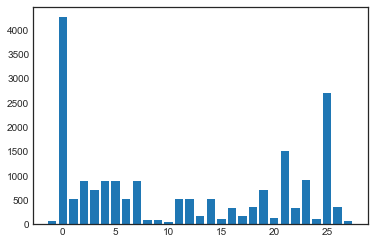

In [238]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [239]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    # print(c0.shape,c1.shape)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [240]:
f1_sub(fname,'sub/protein_classification.csv')

0.5998089187022699

In [241]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.521428056316494

In [242]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5162090779770442

In [243]:
f1_sub(fname,'sub/se_resnext5.csv')

0.594940974297192

In [244]:
f1_sub(fname,'sub/resnet34_0.csv')

0.6140920149287439

In [245]:
f1_sub(fname,'sub/ens0.csv')

0.646259268574183

In [246]:
f1_sub(fname,'sub/irv2_0.csv')

0.6365722120464

In [247]:
f1_sub('bojan/submit_InceptionV3.csv','sub/submit_InceptionV3.csv')

0.6432439747575565

In [248]:
f1_sub('bojan/inceptionv3_2.csv','sub/submit_InceptionV3.csv')

0.5987392720028134

In [249]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_1.csv')

0.4642857142857143

In [250]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_2.csv')

0.1426221052396753

In [251]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','sub/submit_InceptionV3.csv')

0.5918623923200268

In [252]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','bojan/inceptionresnetv2_1.csv')

0.6575760350950599